In [1]:
#!ipython nbconvert offline.ipynb --to python

In [1]:
from online import Online_Model, BeamSearch, Point, Line, Each_Sample_PointSet
from offline import distortion_free_resize, Offline_Model, decode_batch_predictions

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from deslant_img import deslant_img
import tensorflow as tf
import os

In [9]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32
max_len=21


In [10]:
characters = {'W', 'Z', 'h', 'R', ')', 'I', 'U', "'", 'S', ':', 'p', 'q', 't', 'r', 's', 'g', '?', 'D', '!', '0', 'N', 'H', 'X', 'e', 'V', 'y', 'n', '7', '/', 'E', '*', '1', 'Q', '5', 'T', 'i', 'o', 'z', '2', '3', 'M', '&', 'O', 'F', '.', 'Y', 'u', 'l', 'J', 'm', ',', 'w', '9', '"', 'f', 'C', 'a', 'x', '+', 'A', 'j', '-', 'v', 'B', '#', 'L', 'P', 'd', '(', ';', 'G', '4', '6', 'K', 'k', 'b', '8', 'c'}


# In[346]:


from tensorflow.keras.layers.experimental.preprocessing import StringLookup


# In[347]:


AUTOTUNE = tf.data.AUTOTUNE
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [11]:
def get_image(image):
    img = image
    return img

def get_label(label):
    label_ = label
    return label_


def get_dataset(image_path, label):
    image = get_image(image_path)
    label = get_label(label)
    return {"xs": image, "ys": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        get_dataset, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [12]:
from enum import Enum

class Event(Enum):
    PRED_SELECTED = 1
    START_DRAWING = 2
    END_DRAWING = 3
    PRED_SETTED = 4
    POINT_SETTED = 5

In [13]:
# Basic publisher subscriber pattern
subscribers = {}


def unsub(event, callback):
    if event is not None or event != "" \
            and event in subscribers.keys():
        subscribers[event] = list(
            filter(
                lambda x: x is not callback,
                subscribers[event]
            )
        )


def unsub_all():
    global subscribers
    subscribers = {}


def sub(event, callback):
    if not callable(callback):
        raise ValueError("callback must be callable")

    if event is None or event == "":
        raise ValueError("Event cant be empty")

    if event not in subscribers.keys():
        subscribers[event] = [callback]
    else:
        subscribers[event].append(callback)


def pub(event, args):
    if event in subscribers.keys():
        for callback in subscribers[event]:
            callback(args)


In [14]:
import tkinter as tk

# the drawing pad
class WritingPadView(tk.LabelFrame):
    def __init__(self, parent, **kwargs):
        super().__init__(parent, **kwargs)
        # state variables
        self.btn1pressed = False
        self.newline = True
        self.xorig = None
        self.yorig = None
        self.drawing = False
        self.after_list = []
        self.curr_stroke = 0
        self.points = []

        # View
        self.setup_canvas()

    def mouse1press(self, event):
        if not self.drawing:
            pub(Event.START_DRAWING, None)

        self.drawing = True
        self.btn1pressed = True
        self.xorig = event.x
        self.yorig = event.y
        self.curr_stroke += 1
        self.points.append([])
        if self.after_list:
            self.after_cancel(self.after_list.pop(0))

    def mouse1release(self, event):
        self.btn1pressed = False
        self.xorig = None
        self.yorig = None
        # Wait 1s, if mouse1 was not pressed, clear canvas
        after_id = self.after(5000, self.on_end_drawing)
        self.after_list.append(after_id)

    def mousemove(self, event):
        # left click held down
        if self.btn1pressed:
            if self.xorig:
                event.widget.create_line(self.xorig, self.yorig, event.x, event.y,
                                         smooth=tk.TRUE, width=3)
            self.xorig = event.x
            self.yorig = event.y
            # append point to last stroke
            self.points[-1].append((event.x, event.y))

    def setup_canvas(self):
        self.canvas = tk.Canvas(self, bg="lightblue")
        self.canvas.bind("<Motion>", self.mousemove)
        self.canvas.bind("<ButtonPress-1>", self.mouse1press)
        self.canvas.bind("<ButtonRelease-1>", self.mouse1release)
        self.canvas.grid(column=0, row=0, sticky="nsew")

    def on_end_drawing(self):
        self.clear_canvas()
        pub(Event.END_DRAWING, self.points)
        self.points = []

    def clear_canvas(self):
        self.canvas.delete("all")
        self.drawing = False


class PredictedTextView(tk.LabelFrame):

    def __init__(self, parent, **kwargs):
        super().__init__(parent, **kwargs)
        self.setup_textbox()

    def on_predictions_setted(self, preds):
        self.insert_text(preds[0])
        self.set_word_end()

    def setup_textbox(self):
        self.textbox = ScrolledText(self)
        self.textbox.grid(row=0, column=0, sticky="nsew")
        self.textbox.tag_configure("TAG", background="#bee69a")
        self.set_word_start()
        self.set_word_end()

    def get_input(self):
        print(self.textbox.get(1.0, tk.END))

    def insert_text(self, text):
        self.textbox.tag_remove(tk.SEL, 1.0, tk.END)
        self.textbox.delete("WORDSTART", "WORDEND")
        self.textbox.insert("WORDSTART", text, (tk.SEL,))

    # Set the current ending mark as start mark
    def set_word_start(self):
        self.textbox.mark_set("WORDSTART", tk.INSERT)
        self.textbox.mark_gravity("WORDSTART", tk.LEFT)

    def set_word_end(self):
        self.textbox.mark_set("WORDEND", tk.INSERT)


# the top-n predictions for correction
class CorrectionsView(tk.LabelFrame):
    def __init__(self, parent, **kwargs):
        super().__init__(parent, **kwargs)
        self.buttons = []
        self.setup_predictions(8)
        self.setup_correction_canvas()
        
    def setup_correction_canvas(self):
        self.canvas = tk.Canvas(self, bg="lightblue")

    def setup_predictions(self, n):
        for i in range(n):
            b = tk.Button(self)
            b.grid(row=0, column=i, sticky="nsew")
            self.buttons.append(b)
            self.grid_columnconfigure(i, weight=1)

    def update_buttons(self, preds):
        assert (len(preds) == len(self.buttons))
        for i in range(len(self.buttons)):
            self.buttons[i].config(text=preds[i], command=lambda t=preds[i]: pub(Event.PRED_SELECTED, t))


# Source code from tkinter
class ScrolledText(tk.Text):
    def __init__(self, master=None, **kw):
        super(ScrolledText, self).__init__(master=master)
        self.frame = tk.Frame(master)
        self.vbar = tk.Scrollbar(self.frame)
        self.vbar.pack(side=tk.RIGHT, fill=tk.Y)

        kw.update({'yscrollcommand': self.vbar.set})
        tk.Text.__init__(self, self.frame, **kw)
        self.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        self.vbar['command'] = self.yview

        # Copy geometry methods of self.frame without overriding Text
        # methods -- hack!
        text_meths = vars(tk.Text).keys()
        methods = vars(tk.Pack).keys() | vars(tk.Grid).keys() | vars(tk.Place).keys()
        methods = methods.difference(text_meths)

        for m in methods:
            if m[0] != '_' and m != 'config' and m != 'configure':
                setattr(self, m, getattr(self.frame, m))

    def __str__(self):
        return str(self.frame)



In [15]:
class AppModel:
    def __init__(self, pred):
        self.pred = pred()
        self._predictions = []
        self._points = []

    def set_predictions(self, predictions):
        self._predictions = predictions
        pub(Event.PRED_SETTED, predictions)

    def set_points(self, points):
        self._points = points
        pub(Event.POINT_SETTED, points)

    def compute_predictions(self, points):
        self.set_points(points)
        features_online, features_offline = self.pred.get_features(self._points)
        
        predictions = self.pred.predict(features_online, features_offline, 8)
        self.set_predictions(predictions)
        print(predictions)
        return predictions

In [16]:
class DLLSTMpred():
    def __init__(self):
        decoder = BeamSearch(25)
        self.model = Online_Model(preload=True)
        self.offline_model = Offline_Model(preload=True)
        
    def get_features(self, strokes):
        points = []
        for i in range(len(strokes)):
            stroke = strokes[i]
            for x, y in stroke:
                points.append(Point(i, 0, x, y))
        pointset = Each_Sample_PointSet(points=points)
        pointset.preprocessing()
        features_online = pointset.generate_features()
        pointset.preprocessing_offline()
        
        path = "./application.png"
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        res = deslant_img(img)
        img = res.img
        img = np.reshape(img,(img.shape[0],img.shape[1],1))
        img = distortion_free_resize(img, img_size=(128, 32))
        img_feature = tf.cast(img, tf.float32) / 255.
        #print(img_feature.shape)
        img_feature = tf.reshape(img_feature,(1,128,32))
        
        label = ""
        label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
        length = tf.shape(label)[0]
        pad_amount = max_len - length
        label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
        label = tf.reshape(label,(1,21))
        tf_offline = prepare_dataset(img_feature, label)
        
        
        return features_online, tf_offline

    def predict(self, features_online, features_offline, n):
        n = int(n/2)
        x = np.expand_dims(features_online, axis=0)
        results_online = self.model.predict(x, top=n)[0]
        predict_offline = self.offline_model.predict(features_offline)
        beam = predict_offline[0]
        beam = np.reshape(beam,(1,beam.shape[0],beam.shape[1]))
        beam_pred = decode_batch_predictions(pred=beam,top_n=n)
        results_offline = []
        for i in range(n):
            results_offline.append(beam_pred[i][0])
        print(results_online)
        print(results_offline)
        results = [*results_online, *results_offline]
        return results


preloading model weights from ./model/online/online_without_children_NoTimediff_standar_rdg003_resample015_withxy_batch8_final.h5
preloading model weights from./model/offline/offline_without_children_CNN2_batch64_blstm.h5


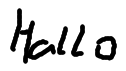

1/1 [==============================] - 2s 2s/step
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
['Hal L o', 'Hal l o', 'Hal L o ', 'Hal L q']
['yu&9;', 'yu9;', 'yu9;', 'au&9;']
['Hal L o', 'Hal l o', 'Hal L o ', 'Hal L q', 'yu&9;', 'yu9;', 'yu9;', 'au&9;']


In [17]:
import tkinter as tk

# Controller
class App(tk.Tk):
    def __init__(self, *args, **kwargs):
        super(App, self).__init__(*args, **kwargs)

        self.title('Handwriting recognition')
        self.geometry('{}x{}'.format(500, 500))

        appmodel = AppModel(DLLSTMpred)
        
        text_area = PredictedTextView(self, text="Text", width=50, height=40, padx=3, pady=3)
        pred_area = CorrectionsView(self, text="Correction", width=450, height=50, pady=3)
        draw_area = WritingPadView(self, text="Writing area", width=450, height=200, padx=3, pady=3)

        # Events
        # Text area
        sub(Event.PRED_SELECTED, lambda x: text_area.insert_text(x))
        sub(Event.START_DRAWING, lambda x: text_area.set_word_start())
        sub(Event.PRED_SETTED, lambda x: text_area.on_predictions_setted(x))
        # Correction area
        sub(Event.PRED_SETTED, lambda x: pred_area.update_buttons(x))
        # Model
        sub(Event.END_DRAWING, lambda x: appmodel.compute_predictions(x))

        # Relative layout of the child views
        self.grid_rowconfigure(0, weight=1)
        self.grid_columnconfigure(0, weight=1)
        text_area.grid(row=0, sticky="nsew")
        pred_area.grid(row=1, sticky="ew")
        draw_area.grid(row=2, sticky="ew")
        text_area.grid_rowconfigure(0, weight=1)
        text_area.grid_columnconfigure(0, weight=1)
        pred_area.grid_rowconfigure(0, weight=1)
        draw_area.grid_columnconfigure(0, weight=1)
        draw_area.grid_rowconfigure(0, weight=1)

    def run(self):
        self.mainloop()

def run_app():
        App().run()

run_app()

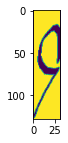

In [14]:
path = "./application.png"
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
res = deslant_img(img)
img = res.img
img = np.reshape(img,(img.shape[0],img.shape[1],1))
img = distortion_free_resize(img, img_size=(128, 32))
img = tf.cast(img, tf.float32) / 255.
plt.imshow(img)
        